# Potato Disease Classification
## Machine Learning Pipeline - Summative Project

**Author:** Edine Noella Mugisha 

**Date:** November 2024  
**Objective:** Build an end-to-end ML pipeline for classifying potato leaf diseases

---

### Problem Statement
Small-scale farmers in Africa lose 30-50% of their potato crop yield to diseases annually. The two main diseases affecting potatoes are:

1. **Early Blight** (Alternaria solani)
2. **Late Blight** (Phytophthora infestans)

### Solution
Build an AI-powered image classification system to:
- Detect diseases early from leaf images
- Provide instant diagnosis with confidence scores
- Offer treatment recommendations
- Enable accessible expert diagnosis

### Dataset
- **Source:** PlantVillage Dataset (https://github.com/spMohanty/PlantVillage-Dataset)
- **Classes:** 3 (Early Blight, Late Blight, Healthy)
- **Total Images:** 2,152
- **Format:** JPG, RGB

In [7]:
# Import Libraries
#-------------------

# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Image Processing
from PIL import Image
import cv2

# Data Download
import urllib.request
import zipfile

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Utilities
import json
import time
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
GPU Available: []


In [8]:
# Data Acquisition
#-----------------

print("\n" + "="*80)
print("DATA ACQUISITION")
print("="*80)

# Project directory
project_dir = '/Users/edine.mugisha/Documents/School/potato_disease_summative_MLOP'

# Data folder
data_root = os.path.join(project_dir, 'data')

# Potato dataset folder (this is where YOUR 3 classes live)
dataset_dir = os.path.join(data_root, 'potato')

# Check if dataset exists
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(
        f"Dataset folder not found at:\n  {dataset_dir}\n"
        "Make sure you placed the folders:\n"
        "  Potato___Early_blight/\n"
        "  Potato___Late_blight/\n"
        "  Potato___healthy/\n"
        "inside the 'data/potato' directory."
    )

print(f"✓ Dataset found at: {dataset_dir}")

# Base path for class folders
base_path = dataset_dir  # all class folders live directly here

# List categories
all_categories = sorted([
    d for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d))
])

print(f"\n✓ Found {len(all_categories)} categories:")
for c in all_categories:
    print(f"  - {c}")



DATA ACQUISITION
✓ Dataset found at: /Users/edine.mugisha/Documents/School/potato_disease_summative_MLOP/data/potato

✓ Found 3 categories:
  - Potato___Early_blight
  - Potato___Late_blight
  - Potato___healthy


In [9]:
# Select potato-related categories
#---------------------------------

print("\n" + "="*80)
print("SELECTING POTATO DISEASE CLASSES")
print("="*80)

# Focus on potato diseases
SELECTED_CLASSES = [
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

categories = [cat for cat in all_categories if cat in SELECTED_CLASSES]

print(f"\n✓ Selected {len(categories)} classes:")
for i, cat in enumerate(categories, 1):
    count = len(os.listdir(os.path.join(base_path, cat)))
    print(f"  {i}. {cat}: {count} images")



SELECTING POTATO DISEASE CLASSES

✓ Selected 3 classes:
  1. Potato___Early_blight: 1000 images
  2. Potato___Late_blight: 1000 images
  3. Potato___healthy: 152 images



EXPLORATORY DATA ANALYSIS

Class Distribution:
          Class  Count
0  Early blight   1000
1   Late blight   1000
2       healthy    152


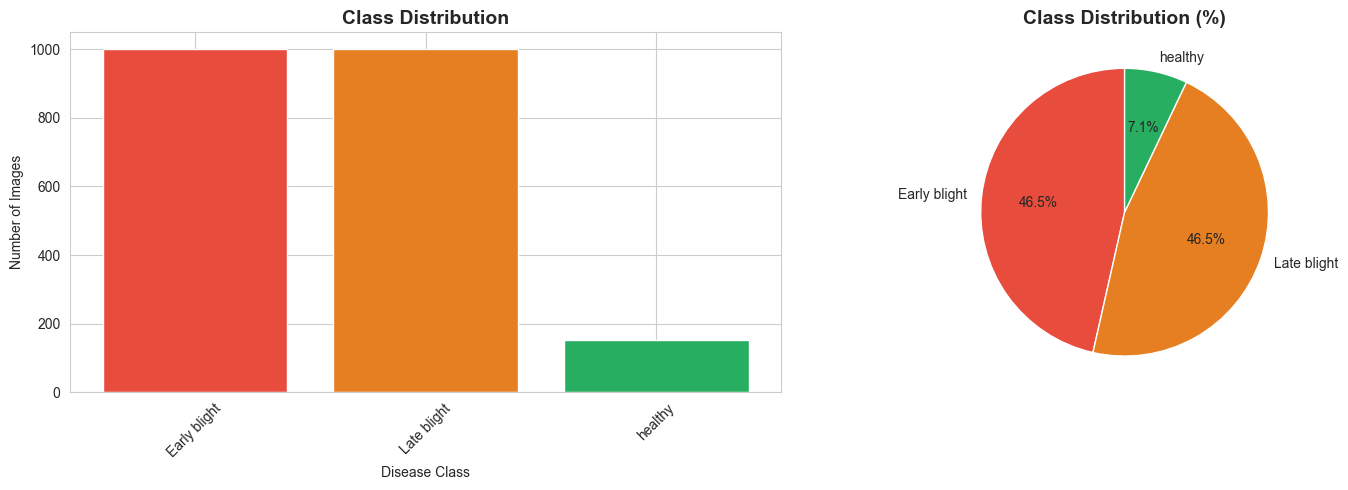


✓ Total images: 2152


In [10]:
# EDA - Class Distribution
#-------------------------

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Count images per class
class_counts = {}
for category in categories:
    class_path = os.path.join(base_path, category)
    class_counts[category] = len(os.listdir(class_path))

# Create DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), 
                         columns=['Class', 'Count'])
df_counts['Class'] = df_counts['Class'].str.replace('Potato___', '').str.replace('_', ' ')

print("\nClass Distribution:")
print(df_counts)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(df_counts['Class'], df_counts['Count'], 
           color=['#e74c3c', '#e67e22', '#27ae60'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Disease Class')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
colors = ['#e74c3c', '#e67e22', '#27ae60']
axes[1].pie(df_counts['Count'], labels=df_counts['Class'], 
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Total images: {df_counts['Count'].sum()}")

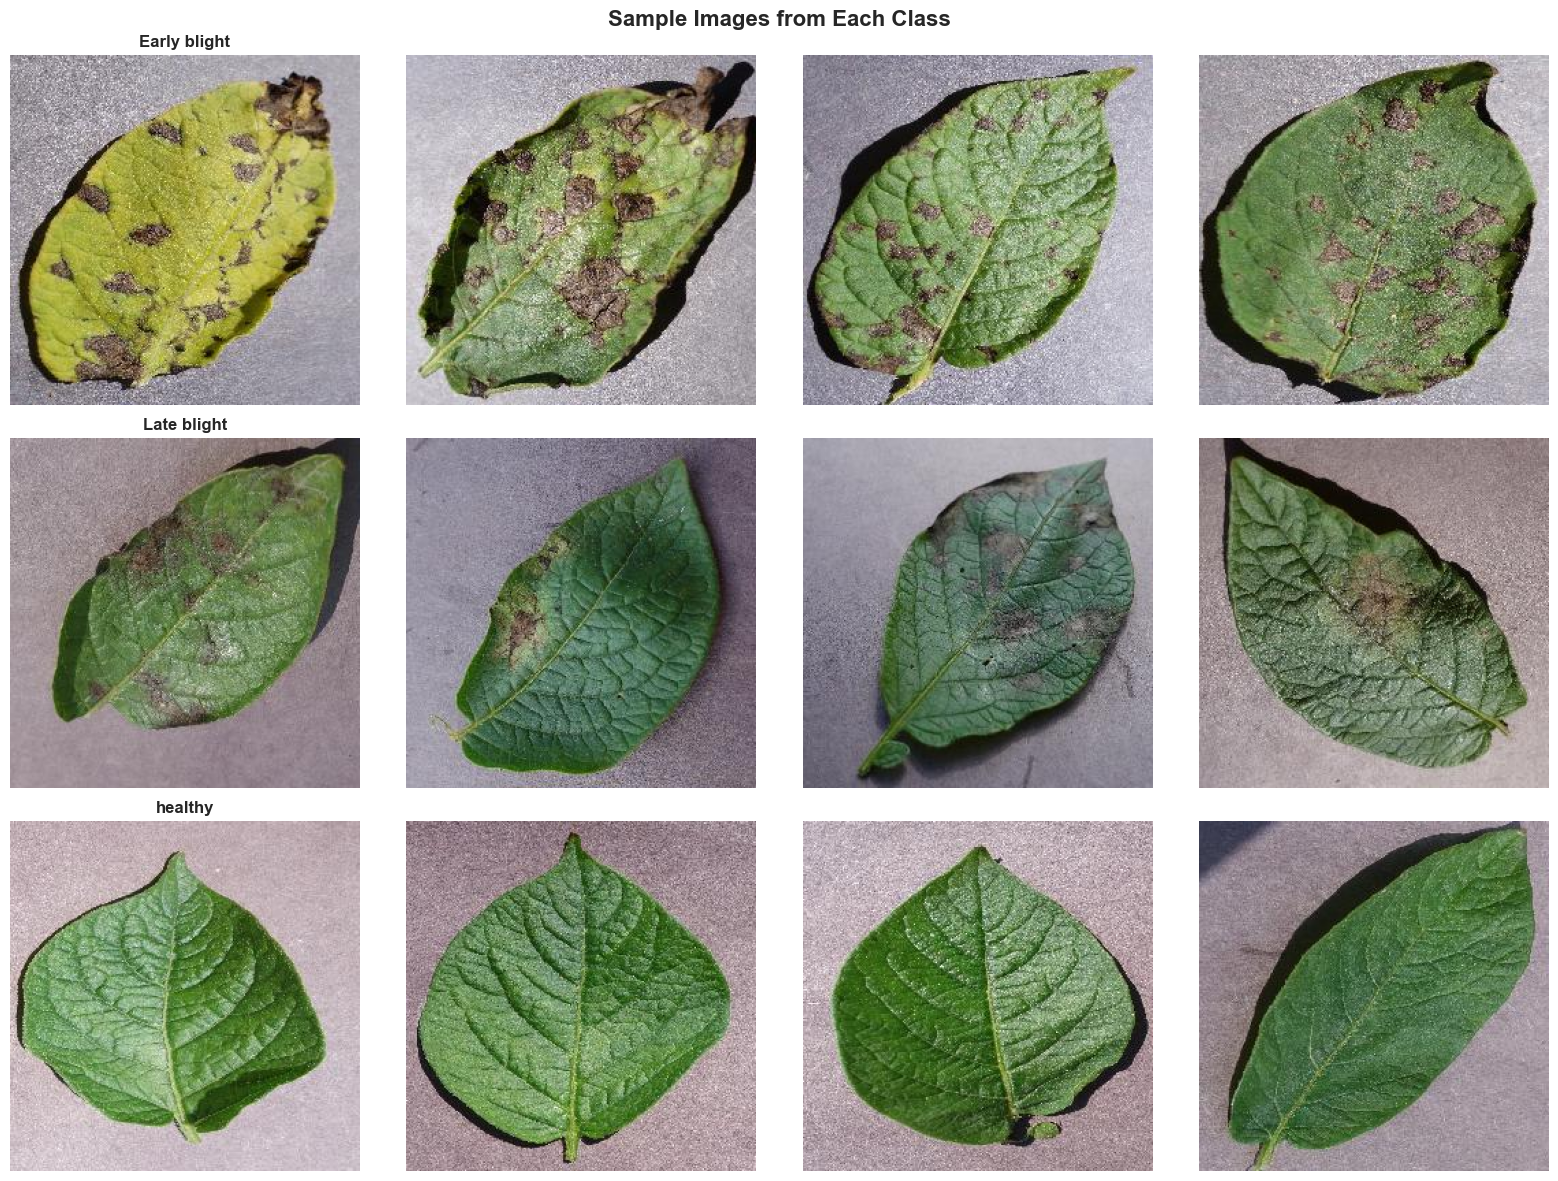

In [11]:
# EDA - Sample Images
#--------------------

# Display sample images from each class
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, category in enumerate(categories):
    class_path = os.path.join(base_path, category)
    images = os.listdir(class_path)[:4]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            clean_name = category.replace('Potato___', '').replace('_', ' ')
            axes[i, j].set_title(clean_name, fontsize=12, fontweight='bold')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

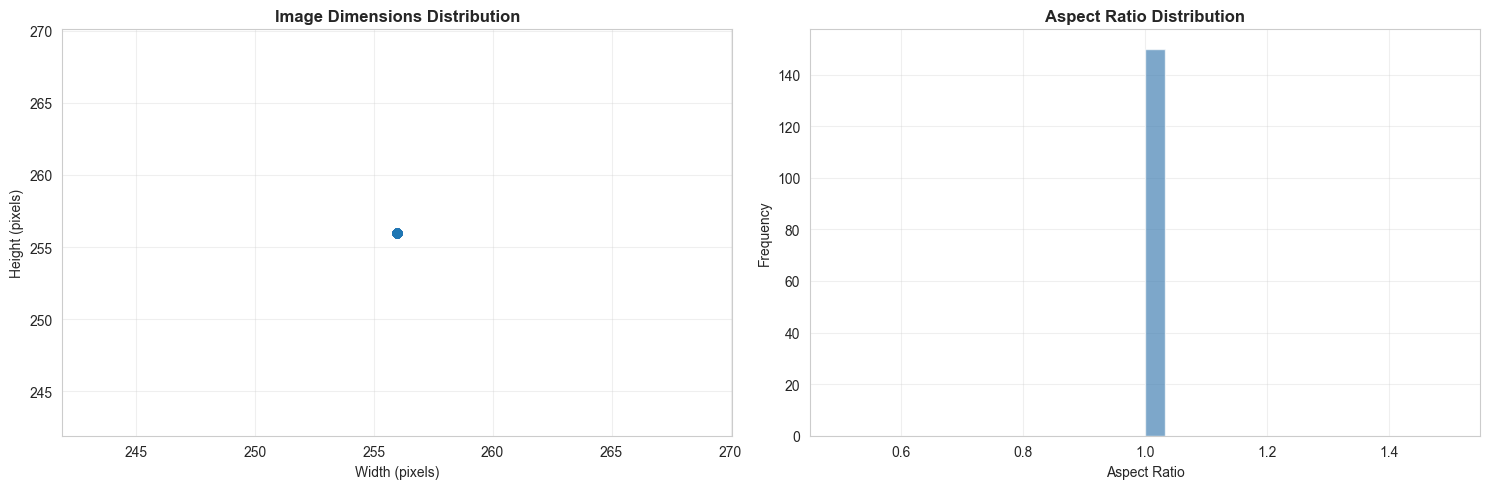

Average Width: 256 pixels
Average Height: 256 pixels
Average Aspect Ratio: 1.00


In [12]:
# Image Properties Analysis
#-------------------------

# Analyze image properties
image_sizes = []
aspect_ratios = []

for category in categories:
    class_path = os.path.join(base_path, category)
    images = os.listdir(class_path)[:50]  # Sample 50 images per class
    
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        width, height = img.size
        image_sizes.append((width, height))
        aspect_ratios.append(width / height)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Image sizes
widths = [s[0] for s in image_sizes]
heights = [s[1] for s in image_sizes]
axes[0].scatter(widths, heights, alpha=0.5)
axes[0].set_title('Image Dimensions Distribution', fontweight='bold')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Height (pixels)')
axes[0].grid(True, alpha=0.3)

# Aspect ratios
axes[1].hist(aspect_ratios, bins=30, color='steelblue', alpha=0.7)
axes[1].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[1].set_xlabel('Aspect Ratio')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_image_properties.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average Width: {np.mean(widths):.0f} pixels")
print(f"Average Height: {np.mean(heights):.0f} pixels")
print(f"Average Aspect Ratio: {np.mean(aspect_ratios):.2f}")

In [13]:
# Data Preprocessing Setup
#-------------------------

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print(f"\nConfiguration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Validation Split: {VALIDATION_SPLIT}")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

print("\n✓ Data augmentation configured")


DATA PREPROCESSING

Configuration:
  Image Size: (256, 256)
  Batch Size: 32
  Validation Split: 0.2

✓ Data augmentation configured


In [14]:
# Load Data
#-----------

# Create generators
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=SELECTED_CLASSES,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=SELECTED_CLASSES,
    shuffle=False
)

# Get class information
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print(f"\n✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {val_generator.samples}")
print(f"✓ Number of classes: {len(class_names)}")
print(f"✓ Class names: {class_names}")

# Save class names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.

✓ Training samples: 1722
✓ Validation samples: 430
✓ Number of classes: 3
✓ Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


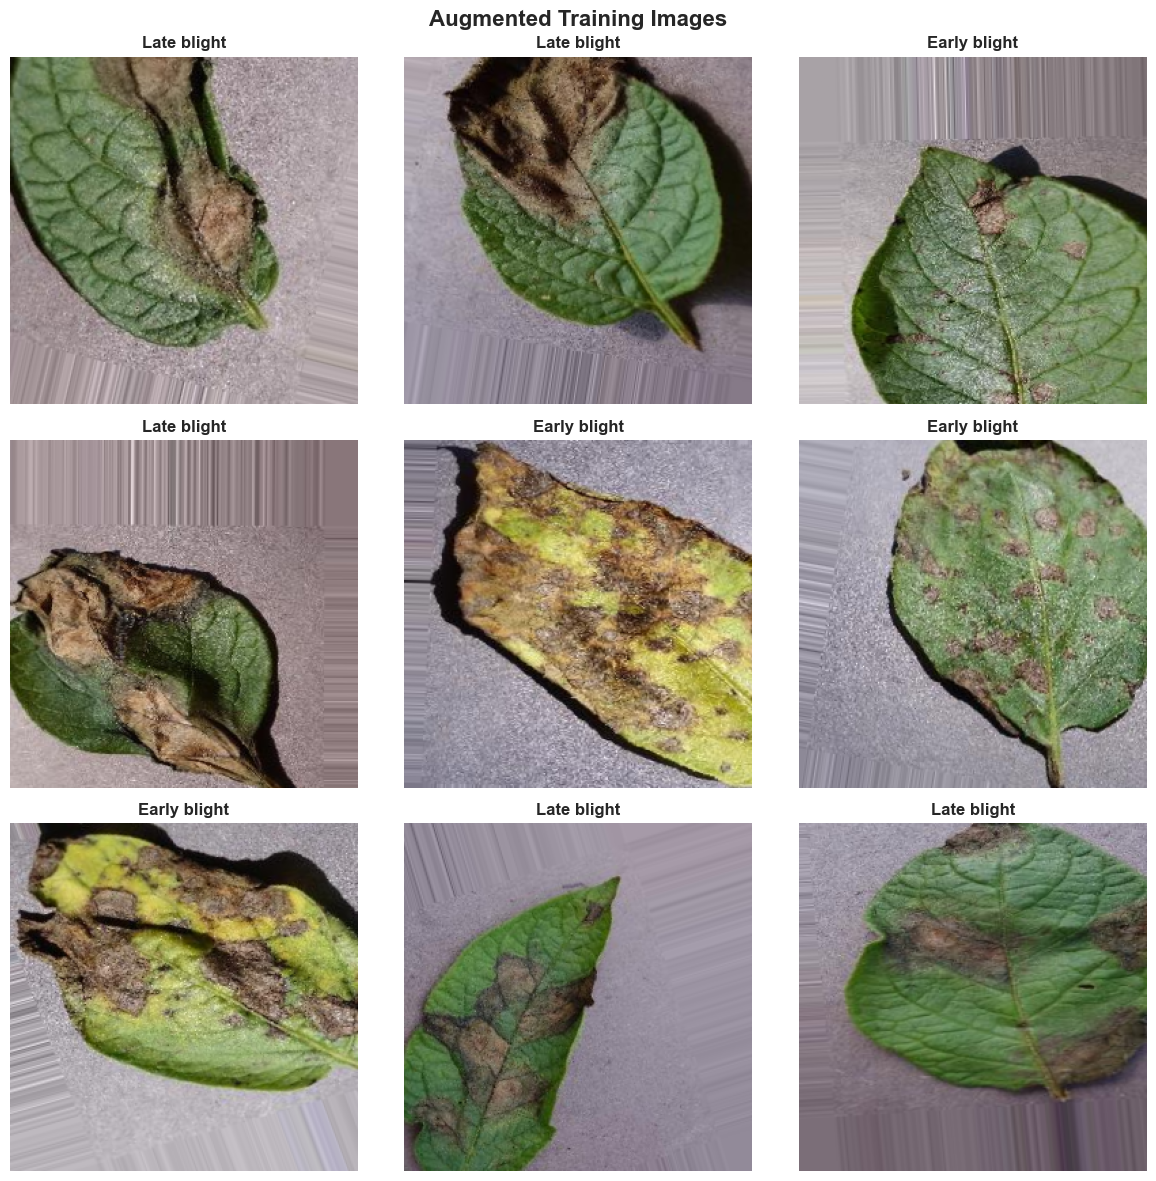

In [15]:
# Visualize Augmentation
#-----------------------

# Visualize data augmentation
def visualize_augmentation(generator, num_samples=9):
    # Get a batch
    images, labels = next(generator)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(num_samples):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        class_name = class_names[class_idx].replace('Potato___', '').replace('_', ' ')
        axes[i].set_title(f'{class_name}', fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('augmented_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_augmentation(train_generator)

In [16]:
# Model Building (Custom CNN + Transfer Learning)
#-----------------------------------------------

print("\n" + "="*80)
print("MODEL BUILDING")
print("="*80)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam

input_shape = IMG_SIZE + (3,)
num_classes = len(class_names)

def build_cnn_model(input_shape, num_classes):
    """
    Simple baseline CNN built from scratch.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


def build_transfer_model(input_shape, num_classes):
    """
    Transfer Learning using MobileNetV2 as feature extractor.
    """
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model for initial training
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Choose which model to use: "cnn" or "transfer"
MODEL_TYPE = "transfer"   # <- change to "cnn" if you want the scratch CNN

if MODEL_TYPE == "cnn":
    model = build_cnn_model(input_shape, num_classes)
    model_name = "potato_cnn"
else:
    model = build_transfer_model(input_shape, num_classes)
    model_name = "potato_mobilenetv2"

# Compile model
learning_rate = 1e-4
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✓ Model type: {MODEL_TYPE}")
print(f"✓ Model name: {model_name}")
model.summary()



MODEL BUILDING
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

✓ Model type: transfer
✓ Model name: potato_mobilenetv2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Training Setup with Callbacks
#--------------------------------

print("\n" + "="*80)
print("TRAINING SETUP")
print("="*80)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Make directory for models
os.makedirs("models", exist_ok=True)

checkpoint_path = os.path.join("models", f"{model_name}_best.h5")

checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

EPOCHS = 20  # you can increase to e.g. 30 if training is stable

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"\nTraining configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")
print(f"  Checkpoint path: {checkpoint_path}")



TRAINING SETUP

Training configuration:
  Epochs: 20
  Steps per epoch: 53
  Validation steps: 13
  Checkpoint path: models/potato_mobilenetv2_best.h5


In [18]:
# Model Training
#---------------

print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✓ Training completed in {training_time/60:.2f} minutes")



MODEL TRAINING
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5474 - loss: 1.0264
Epoch 1: val_accuracy improved from None to 0.90865, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.6444 - loss: 0.8343 - val_accuracy: 0.9087 - val_loss: 0.3530 - learning_rate: 1.0000e-04
Epoch 2/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8438 - loss: 0.5018
Epoch 2: val_accuracy improved from 0.90865 to 0.91106, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8438 - loss: 0.5018 - val_accuracy: 0.9111 - val_loss: 0.3504 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8042 - loss: 0.5121
Epoch 3: val_accuracy improved from 0.91106 to 0.92788, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.8160 - loss: 0.4701 - val_accuracy: 0.9279 - val_loss: 0.2406 - learning_rate: 1.0000e-04
Epoch 4/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.8125 - loss: 0.4447
Epoch 4: val_accuracy improved from 0.92788 to 0.93029, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8125 - loss: 0.4447 - val_accuracy: 0.9303 - val_loss: 0.2393 - learning_rate: 1.0000e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8485 - loss: 0.3830
Epoch 5: val_accuracy improved from 0.93029 to 0.94952, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.8621 - loss: 0.3571 - val_accuracy: 0.9495 - val_loss: 0.1889 - learning_rate: 1.0000e-04
Epoch 6/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.9062 - loss: 0.2484
Epoch 6: val_accuracy did not improve from 0.94952
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9062 - loss: 0.2484 - val_accuracy: 0.9471 - val_loss: 0.1883 - learning_rate: 1.0000e-04
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8799 - loss: 0.3195
Epoch 7: val_accuracy improved from 0.94952 to 0.96154, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.8864 - loss: 0.2991 - val_accuracy: 0.9615 - val_loss: 0.1616 - learning_rate: 1.0000e-04
Epoch 8/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.8750 - loss: 0.3778
Epoch 8: val_accuracy did not improve from 0.96154
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8750 - loss: 0.3778 - val_accuracy: 0.9615 - val_loss: 0.1610 - learning_rate: 1.0000e-04
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9145 - loss: 0.2311
Epoch 9: val_accuracy improved from 0.96154 to 0.96635, saving model to models/potato_mobilenetv2_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - accuracy: 0.9130 - loss: 0.2329 - val_accuracy: 0.9663 - val_loss: 0.1495 - learning_rate: 1.0000e-04
Epoch 10/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.9062 - loss: 0.2051
Epoch 10: val_accuracy did not improve from 0.96635
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9062 - loss: 0.2051 - val_accuracy: 0.9663 - val_loss: 0.1488 - learning_rate: 1.0000e-04
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9149 - loss: 0.2280
Epoch 11: val_accuracy did not improve from 0.96635
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.9213 - loss: 0.2218 - val_accuracy: 0.9615 - val_loss: 0.1390 - learning_rate: 1.0000e-04
Epoch 12/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9688 - loss: 0.1900
Epoch 12: val_accuracy did not improve from 0.96635
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9688 - loss: 0.1900 - val_accuracy: 0.9615 - val_loss: 0.1375 - learning_rate: 1.0000e-04
Ep


TRAINING HISTORY VISUALIZATION

History keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']


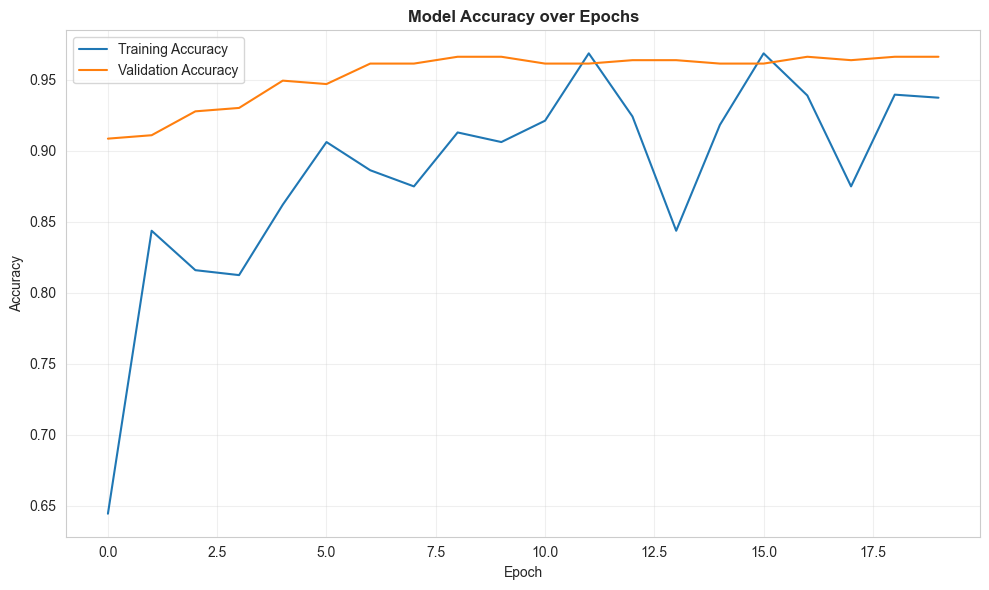

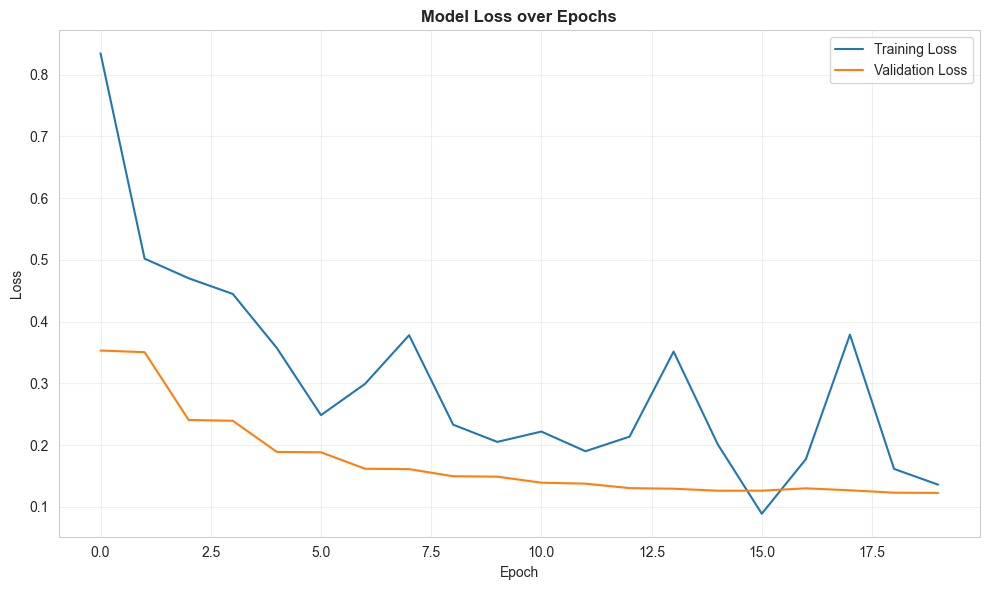


✓ Training curves saved as PNG
✓ History saved as JSON


In [19]:
# Training History Visualization
#--------------------------------

print("\n" + "="*80)
print("TRAINING HISTORY VISUALIZATION")
print("="*80)

# Convert history to DataFrame
history_df = pd.DataFrame(history.history)
print("\nHistory keys:", history_df.columns.tolist())

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Save history to JSON (for reproducibility)
with open(f'{model_name}_history.json', 'w') as f:
    json.dump(history.history, f)

print("\n✓ Training curves saved as PNG")
print("✓ History saved as JSON")


In [20]:
# Model Evaluation
#-----------------

print("\n" + "="*80)
print("MODEL EVALUATION ON VALIDATION SET")
print("="*80)

# Ensure we evaluate with the best weights (best checkpoint already restored by EarlyStopping)
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")



MODEL EVALUATION ON VALIDATION SET
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9628 - loss: 0.1262

Validation Loss: 0.1262
Validation Accuracy: 0.9628


In [21]:
# Classification Report and Accuracy
#-----------------------------------

print("\n" + "="*80)
print("DETAILED EVALUATION METRICS")
print("="*80)

# Reset generator to start from beginning
val_generator.reset()

# Get predictions (probabilities)
y_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# True labels
y_true = val_generator.classes
target_names = list(val_generator.class_indices.keys())

# Overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {acc:.4f}\n")

# Classification report
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(report)



DETAILED EVALUATION METRICS
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step

Overall Accuracy: 0.9628

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.95      0.97       200
 Potato___Late_blight       0.93      0.99      0.96       200
     Potato___healthy       0.93      0.87      0.90        30

             accuracy                           0.96       430
            macro avg       0.95      0.94      0.94       430
         weighted avg       0.96      0.96      0.96       430




CONFUSION MATRIX


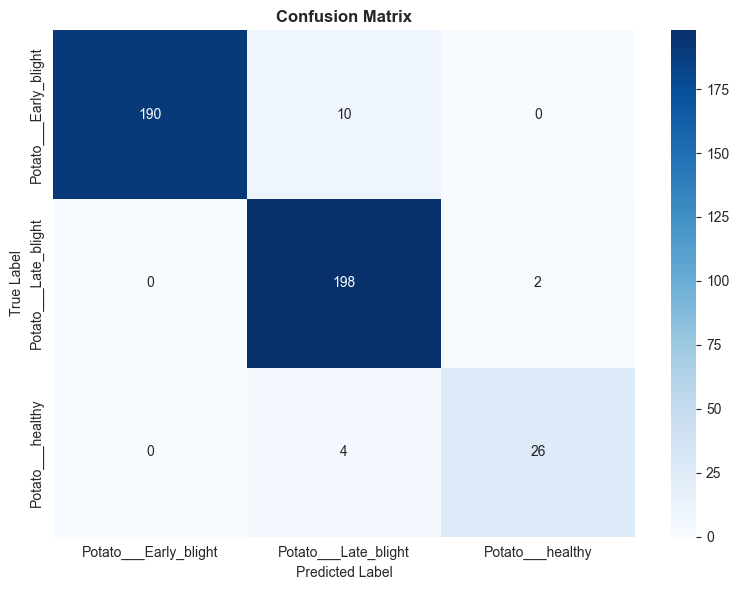

In [22]:
# Confusion Matrix
#------------------

print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



ROC CURVES (ONE-vs-REST)


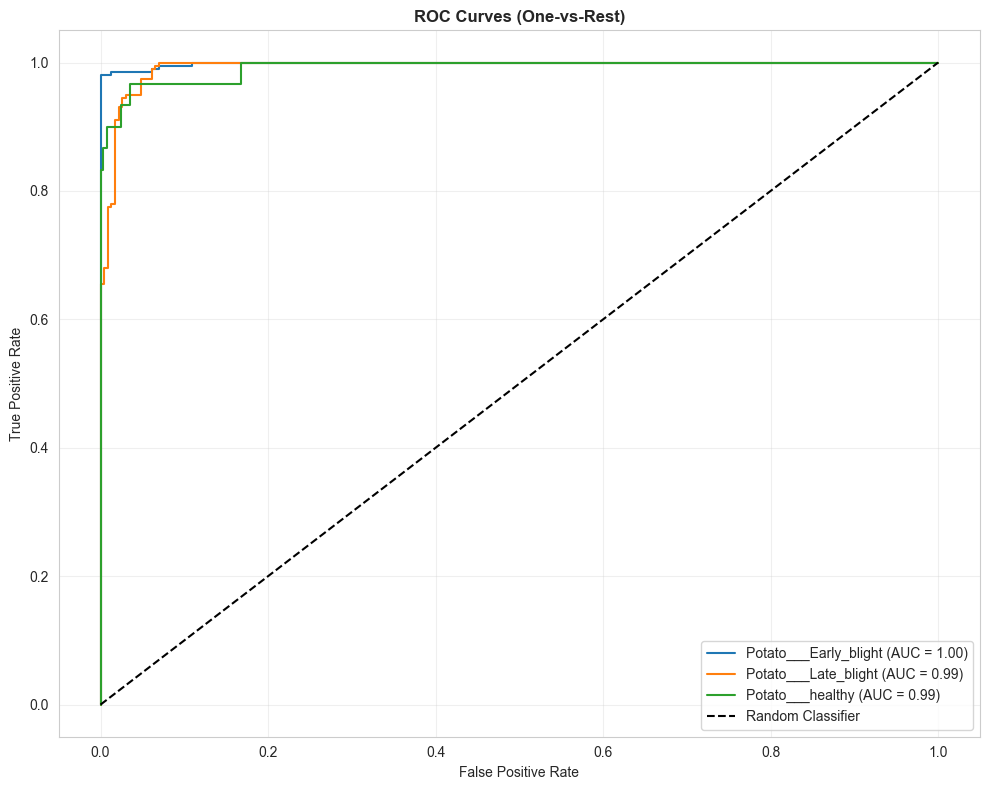


AUC scores per class:
  Potato___Early_blight: 0.999
  Potato___Late_blight: 0.993
  Potato___healthy: 0.992


In [23]:
# ROC Curves (One-vs-Rest)
#------------------------

print("\n" + "="*80)
print("ROC CURVES (ONE-vs-REST)")
print("="*80)

from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Binarize labels
y_true_bin = to_categorical(y_true, num_classes=num_classes)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(target_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curves (One-vs-Rest)', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAUC scores per class:")
for i, class_name in enumerate(target_names):
    print(f"  {class_name}: {roc_auc[i]:.3f}")



SAMPLE PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


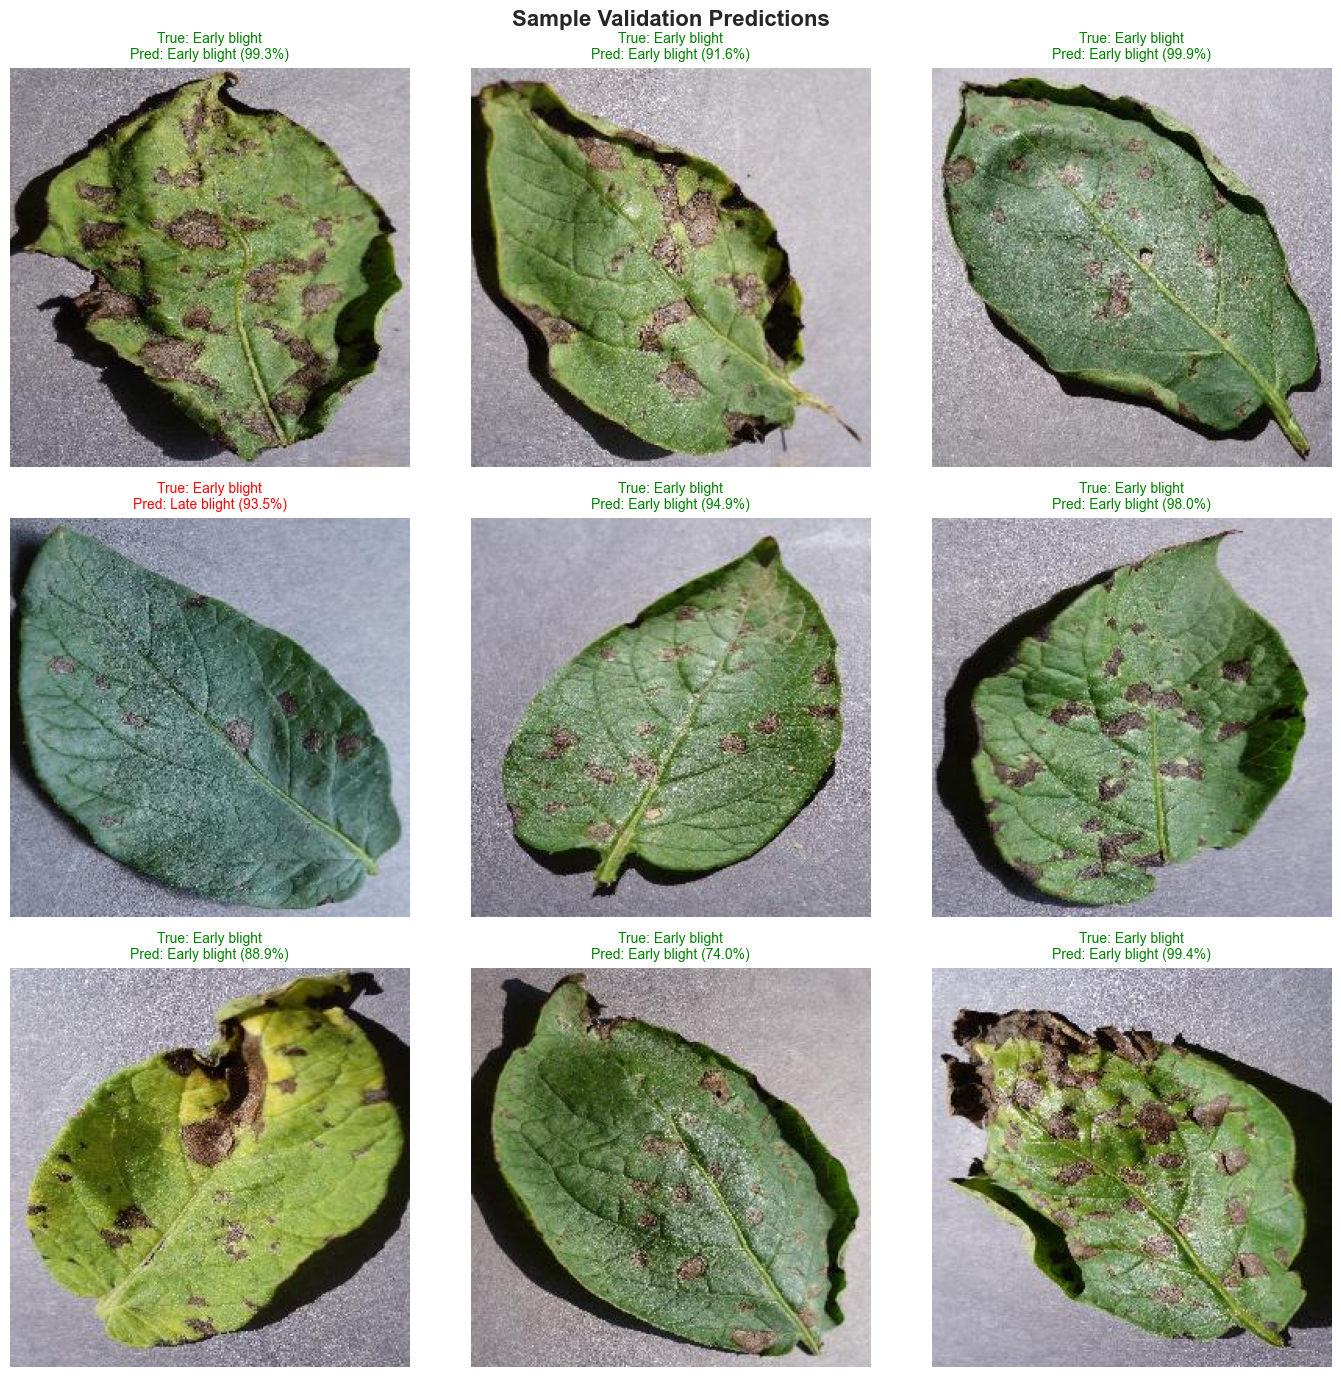

In [24]:
# Sample Predictions
#-------------------

print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Get one batch of validation images
val_batch_images, val_batch_labels = next(val_generator)

# Get predictions for this batch
batch_prob = model.predict(val_batch_images)
batch_pred = np.argmax(batch_prob, axis=1)
batch_true = np.argmax(val_batch_labels, axis=1)

num_samples = 9
plt.figure(figsize=(14, 14))

for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    img = val_batch_images[i]
    true_label = target_names[batch_true[i]]
    pred_label = target_names[batch_pred[i]]
    confidence = np.max(batch_prob[i]) * 100

    plt.imshow(img)
    plt.axis('off')
    
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(
        f"True: {true_label.replace('Potato___', '').replace('_', ' ')}\n"
        f"Pred: {pred_label.replace('Potato___', '').replace('_', ' ')} ({confidence:.1f}%)",
        color=title_color,
        fontsize=10
    )

plt.suptitle('Sample Validation Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


In [28]:
# Save Final Model and Artifacts
#-------------------------------

print("\n" + "="*80)
print("SAVING MODEL & ARTIFACTS")
print("="*80)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = os.path.join("models", f"{model_name}_{timestamp}")
os.makedirs(export_dir, exist_ok=True)

# 1. Save Keras H5 model 
h5_path = os.path.join(export_dir, f"{model_name}.h5")
model.save(h5_path)
print(f"✓ Model saved as H5 at: {h5_path}")

# 2. Save class names
class_names_path = os.path.join(export_dir, "class_names.json")
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)
print(f"✓ Class names saved at: {class_names_path}")

# 3. Save training history
history_path = os.path.join(export_dir, "training_history.json")
with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f"✓ Training history saved at: {history_path}")

print("\nAll artifacts saved successfully.")



SAVING MODEL & ARTIFACTS
✓ Model saved as H5 at: models/potato_mobilenetv2_20251127_150935/potato_mobilenetv2.h5
✓ Class names saved at: models/potato_mobilenetv2_20251127_150935/class_names.json
✓ Training history saved at: models/potato_mobilenetv2_20251127_150935/training_history.json

All artifacts saved successfully.
